# Neural Radiance Field Scene Representation


![](../images/2023/06/09/nerf_explain/nerf-architect.png)

用一个MLP网络映射 输入(x,y,z,θ,φ) -> 输出（rgb, σ）


网络结构

![网络结构](../images/2023/06/09/nerf_explain/nerf_block.png)


对应的代码实现：




In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class NeRF(nn.Module):
    def __init__(self, D=8, W=256, input_ch=3, input_ch_views=3, output_ch=4, skips=[4], use_viewdirs=False):
        """ 
        """
        super(NeRF, self).__init__()
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        self.pts_linears = nn.ModuleList(
            [nn.Linear(input_ch, W)] + 
            [nn.Linear(W, W) if i not in self.skips else nn.Linear(W + input_ch, W) for i in range(D - 1)])

        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views + W, W // 2)])
        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W) 
            self.alpha_linear = nn.Linear(W, 1) # 输出体密度
            self.rgb_linear = nn.Linear(W // 2, 3) #输出颜色
        else:
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x):
        input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)
        h = input_pts
        for i, l in enumerate(self.pts_linears):
            h = self.pts_linears[i](h)
            h = F.relu(h)
            if i in self.skips:
                h = torch.cat([input_pts, h], -1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], -1)

            for i, l in enumerate(self.views_linears):
                h = self.views_linears[i](h)
                h = F.relu(h)

            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], -1)
        else:
            outputs = self.output_linear(h)

        return outputs

In [ ]:
import torch.onnx
import netron

embed_fn, input_ch = get_embedder(10)
embeddirs_fn, input_ch_views = get_embedder(4)
print(input_ch, input_ch_views)

ray_o = torch.Tensor([3, 2, 5])
ray_d = torch.Tensor([1, 1, 1])
inputs = torch.cat([embed_fn(ray_o), embeddirs_fn(ray_d)], -1)
print(inputs.shape)

model = NeRF(input_ch=input_ch, input_ch_views=input_ch_views, use_viewdirs=True)  
y = model(inputs)
torch.onnx.export(model, inputs, './NeRF.pth')
netron.start("./NeRF.pth")

# 位置编码

采用和Transformer同样的技术进行位置编码，将坐标xyz映射到[-1,1]的连续空间中，这样做的好处：
* 有限的数值范围，避免出在输入数据上欠拟合
* 将输入坐标映射到高维空间（神经网络倾向于学习低频函数，使用高频函数将输入映射到高位空间，可以更好地拟合高频变化的数据）

![](../images/2023/06/09/nerf_explain/Position_Enc.png)


Transformer位置编码：https://zhuanlan.zhihu.com/p/454482273

In [58]:
class Embedder:
    def __init__(self, periodic_fns, input_dims=3, include_input=True, max_freq=10, N_freqs=10, log_sampling=True):
        embed_fns = []
        
        out_dim = 0
        if include_input:
            embed_fns.append(lambda x: x)
            out_dim += input_dims

        if log_sampling:
            freq_bands = 2. ** torch.linspace(0., max_freq, steps=N_freqs)
        else:
            freq_bands = torch.linspace(2. ** 0., 2. ** max_freq, steps=N_freqs)

        for freq in freq_bands:
            for p_fn in periodic_fns:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq: p_fn(x * freq))
                out_dim += input_dims

        self.embed_fns = embed_fns
        self.out_dim = out_dim

    def embed(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], -1)


def get_embedder(multires):
    embedder_obj = Embedder(periodic_fns=[torch.sin, torch.cos], max_freq=multires-1, N_freqs=multires)
    embed = lambda x, eo=embedder_obj: eo.embed(x)
    return embed, embedder_obj.out_dim

In [37]:
image_url='../images/2023/06/09/nerf_explain/Position_Enc.png'

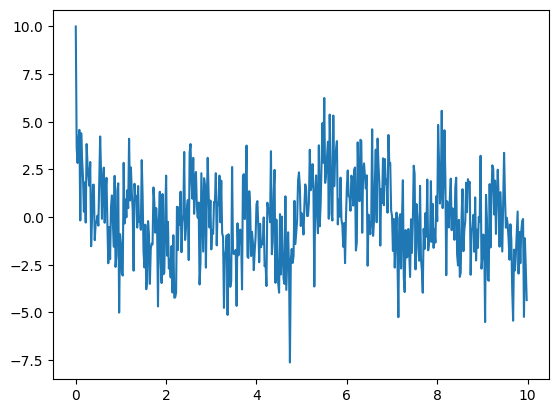

In [60]:
freq_bands = 2. ** np.linspace(0., 10, 10)

def visual_func(f, x):
    plt.plot(x, f(x))
    
visual_func(lambda t: np.sum([np.cos(freq*t) for freq in freq_bands], axis=0), x)

In [12]:
torch.linspace(0., 10, steps=10), np.linspace(0, 10, 10)

(tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
          8.8889, 10.0000]),
 array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
         5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ]))

In [ ]:

from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils import plotly_utils as vis

cx = 20.0
cy = 10.0
fx = 20.0
fy = 20.0

c2w = torch.eye(4)[None, :3, :]

camera = Cameras(fx=fx, fy=fy, cx=cx, cy=cy, camera_to_worlds=c2w, camera_type=CameraType.PERSPECTIVE)
fig = vis.vis_camera_rays(camera)
fig.show()